# Process XML

In [ ]:
# REF: https://docs.python.org/3/library/xml.etree.elementtree.html

In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd

In [2]:
tree = ET.parse('/Users/jiesun/Dropbox/2021_FALL/DanaFaber/Camelyon/tumor_110.xml') # TO EDIT


In [4]:
# Convert these into X and Y by annotation groups

def get_coords(tree):
    """
    input: 
        tree: xml ElementTree object
    output: 
        polys: dictionary. key = annotation 0, 1, etc. value = polygon coordinates 
        groups: dictionary. key = annotation 0, 1, etc. value = partofgroup: _0 or _2
    """
    
    
    root = tree.getroot() #root element
    
    polys = {} # key = annotation 0, 1, etc. value = polygon coordinates 
    groups = {} # key = annotation 0, 1, etc. value = partofgroup: _0 or _2

    for item in root.findall('Annotations/Annotation'):

            # initialize for each Annotation group
            x_co = []
            y_co = []
            name = item.get('Name') #retuns: Annotation 0,1,2,...
            group = item.get('PartOfGroup') #returns: _0,_2

            for child in item.findall('Coordinates/Coordinate'):

                x = child.get('X') # returns: 0,1,2,
                x_co.append(x)
                y = child.get('Y') # returns: 0,1,2,
                y_co.append(y)

            # make into list of coords
            x_co = np.array(x_co,dtype=np.float32)
            y_co = np.array(y_co,dtype=np.float32)
            coo = list(zip(x_co,y_co))

            # save into dict
            polys[name] = coo
            groups[name] = group
    
    return polys, groups
    

In [5]:
polys, groups = get_coords(tree)

# Make into a polygon

In [ ]:
# REF: 
# https://stackoverflow.com/questions/14697442/faster-way-of-polygon-intersection-with-shapely
# https://shapely.readthedocs.io/en/stable/manual.html#polygons

In [8]:
pip install shapely

Note: you may need to restart the kernel to use updated packages.


In [9]:
from shapely.geometry import box, Polygon
from shapely.ops import cascaded_union
from shapely.strtree import STRtree
from shapely.geometry import MultiPolygon

import matplotlib.pyplot as plt

## Example with 1 polygon

In [10]:
# get 1 polygon
polygon = Polygon(polys['Annotation 0'])

In [11]:
# inspect the polygon size
polygon.area

582680757.9844236

In [12]:
# create a shapely Tree object
s = STRtree([polygon])

In [65]:
# similar to our tile
query_geom = Polygon([(-1, -1), (2, 0), (2, 2), (-1, 2)])
# Returns a list of all geometries in the s(strtree) whose extents intersect the extent of query_geom. 
result = s.query(query_geom)

In [67]:
# does my polygon intersect with the query_geom (i.e. tile)? 
polygon in result

False

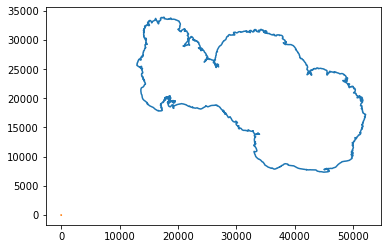

In [70]:
# visualize
plt.plot(*polygon.exterior.xy)
plt.plot(*query_geom.exterior.xy)

## Multiple polygons

In [71]:
# Group of polygons
polygons = [Polygon(polys[k]) for k in polys.keys()] # 39 polygons here

In [82]:
# get Shapley object
s = STRtree(polygons)
# your query grid: for illustration only 
query_geom = Polygon([(20000,20000), (30000, 20000), (30000,30000), (20000, 30000)])
# result
result = s.query(query_geom)

In [89]:
# the first polygon intersects with query_geom?
polygons[20] in result

False

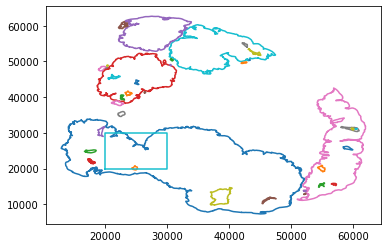

In [83]:
# plot
for p in polygons:
    plt.plot(*p.exterior.xy)
plt.plot(*query_geom.exterior.xy)

In [87]:
# Count 

from collections import Counter
Counter(groups.values()) #looks like _2 means no cancer? 

Counter({'_0': 21, '_2': 18})

In [ ]:
# Consider: take polygons, fill in a pixel level mask (turning a 1 and 0 per pixel)
# To do: load image with downsized, turn this into a pipeline
